<a href="https://colab.research.google.com/github/lylemp/Data-Practice-Notebooks/blob/master/Deep_Learning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install ray
!pip uninstall -y pyarrow # And then restart runtime

In [0]:
import ray

In [3]:
!pip install tensorflow
#!pip install tensorflow-gpu
!sudo pip install keras


# Loading data with Keras

In [4]:
from keras.datasets import mnist # or some other built-in dataset

# mnist dataset: grayscale image data consisting of handwritten digits

Using TensorFlow backend.


Keras is using TensorFlow to perform computations.

# Importing some Keras utilities 

In [0]:
import keras.utils.np_utils as ku
import keras.models as models
import keras.layers as layers

from keras import regularizers

import numpy as np
import pandas as po
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Exploratory Data Analysis

In [7]:
print(train_images[4].shape)

(28, 28)


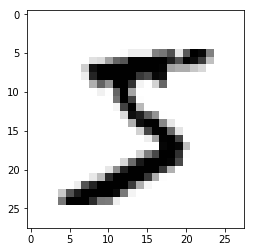

Label = 5


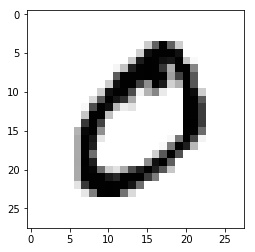

Label = 0


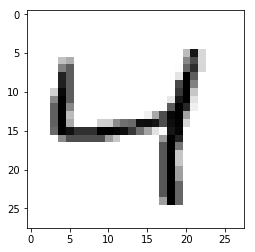

Label = 4


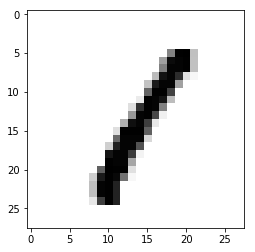

Label = 1


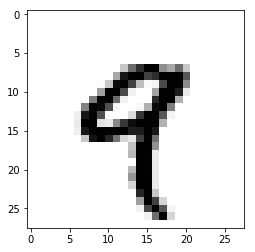

Label = 9


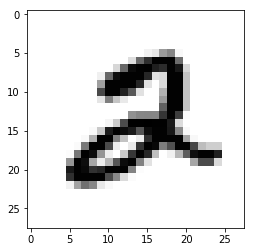

Label = 2


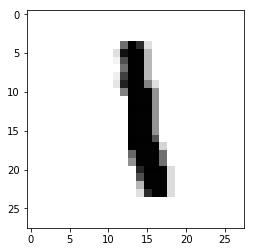

Label = 1


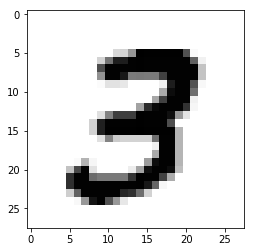

Label = 3


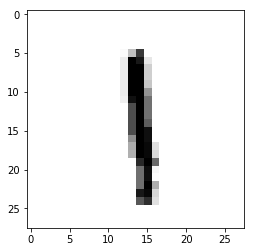

Label = 1


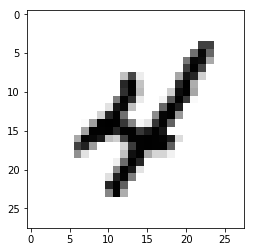

Label = 4


In [8]:
for i in range(10):
  plt.imshow(train_images[i],
          cmap = plt.cm.binary) #black/white color map
  plt.show()
  print("Label = " + str(train_labels[i]))

In [9]:
# pixel values of the fourth image
po.Series(train_images[4].reshape(28*28,)).unique()

array([  0,  55, 148, 210, 253, 113,  87, 232, 252, 189, 168,   4,  57,
       242, 190,  65,   5,  12, 182, 116,  96, 183,  14,  92, 225,  21,
       132, 146, 215,  79, 126, 247, 176,   9,   8,  78, 245, 129,  16,
        36, 201, 169,  11,  22,  30, 119, 197, 241, 251,  77, 231, 226,
       227, 235, 217, 138,  42,  24, 192, 143,  62, 255, 109,  71, 106,
        45, 218,  56, 184, 170, 147], dtype=uint64)

In [10]:
# frequencies for each number
counts = po.Series(train_labels).value_counts().sort_index()
counts

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

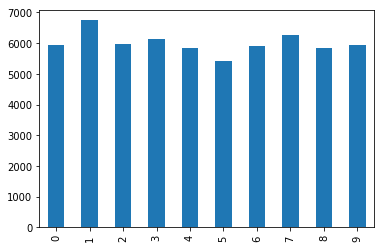

In [11]:
counts.plot(kind = 'bar')

In [12]:
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [13]:
print(train_labels.shape, test_labels.shape)

(60000,) (10000,)


# Data Cleaning (for model training)

## Image standardizing and flattening

Currently, the training data is held in a 3D tensor (60000 x 28 x 28). The 28 x 28 pixel images is on Gray Scale (so value range is 0-255), but we scale the pixel values to the range (0-1) by dividing by 255. Also, we want to flatten it to 2D.

In [14]:
# Standardizing pixel values

print("Original pixel values:\n " + str(train_images[0][5]))

standardized_train_images = train_images.astype('float32')/255
print("Standardized pixel values:\n " + str(standardized_train_images[0][5]))


Original pixel values:
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
 175  26 166 255 247 127   0   0   0   0]
Standardized pixel values:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01176471 0.07058824 0.07058824 0.07058824 0.49411765 0.53333336
 0.6862745  0.10196079 0.6509804  1.         0.96862745 0.49803922
 0.         0.         0.         0.        ]


In [15]:
# Flattening original data

print("2D Tensor: " + str(standardized_train_images[0][0:5])) # Displaying the first image's 'top' 5 rows

flat_standard_train_images = standardized_train_images.reshape(60000, # we still want 60000 instances to train on...
                                                              28 * 28 # but we can flatten the previously 2D pixel values into a single, 1D array
                                                              )

print("1D Tensor: " + str(flat_standard_train_images[0][0:5])) # Displaying the first image's 'top' 5 rows

2D Tensor: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
1D Tensor: [0. 0. 0. 0. 0.]


And we now apply the same data transformations to our testing data.

In [0]:
flat_standard_test_images = ((test_images.astype("float32")/255)
                             .reshape(10000, 28 * 28)
                            )

## One-Hot Encoding our Labels

Currently, our label values range from 0-9. While there are standard procedures for multiclass classification, it is often easier to use a "One vs. Rest" scheme. In Pandas, you may know it as "dummying."

Keras has a similar function to Pandas's get_dummies() method -- to_categorical() (not to confuse with Pandas's to_categorical method).


In [17]:
dummied_train_labels = ku.to_categorical(train_labels)
dummied_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [18]:
dummied_test_labels = ku.to_categorical(test_labels)
dummied_test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Defining a (Sequential) Model

Terminology:
* 'relu' activation: a non-linear function applied to (essentially) a linear regression model

* 'softmax' activation: In a one-vs-rest scheme: out of all the labels, it selects the one that has the largest probability of being the 'correct' answer.

## Model Initialization

In [19]:
nn = models.Sequential()

# First "Hidden" layer
nn.add(layers.Dense(512,
                   activation = 'relu',
                   input_shape = (28*28, )) # Defines input layer
      )

# Output layer
nn.add(layers.Dense(len(po.Series(train_labels).unique()), # number of neurons in this layer should be equal to the range of possible labels (0-9)
                    activation = 'softmax' # Appropriate since we are doing multiclass classification
                   ) 
      )

W0807 20:06:36.755384 140013232560000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 20:06:36.775705 140013232560000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 20:06:36.780610 140013232560000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



## Model Compilation

In [20]:
nn.compile(optimizer = 'rmsprop', # Type of Stochastic Gradient Descent 
          loss = 'categorical_crossentropy', # See Data 100 Notes
          metrics = ['accuracy']) # Basic metric

W0807 20:06:36.819994 140013232560000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 20:06:36.849467 140013232560000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



## Model Fitting

In [21]:
num_epochs = 10
hists = nn.fit(flat_standard_train_images, dummied_train_labels,
       epochs = num_epochs
      )


W0807 20:06:36.969120 140013232560000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0807 20:06:37.037268 140013232560000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
60000/60000 [==============================] - 11s 189us/step - loss: 0.2028 - acc: 0.9409
Epoch 2/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0905 - acc: 0.9739
Epoch 3/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.0641 - acc: 0.9817
Epoch 4/10
60000/60000 [==============================] - 11s 183us/step - loss: 0.0503 - acc: 0.9860
Epoch 5/10
60000/60000 [==============================] - 11s 185us/step - loss: 0.0414 - acc: 0.9889
Epoch 6/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.0330 - acc: 0.9912
Epoch 7/10
60000/60000 [==============================] - 11s 182us/step - loss: 0.0270 - acc: 0.9929
Epoch 8/10
60000/60000 [==============================] - 11s 184us/step - loss: 0.0223 - acc: 0.9943
Epoch 9/10
60000/60000 [==============================] - 11s 181us/step - loss: 0.0195 - acc: 0.9950
Epoch 10/10
60000/60000 [==============================] - 11s 184us/step - loss: 

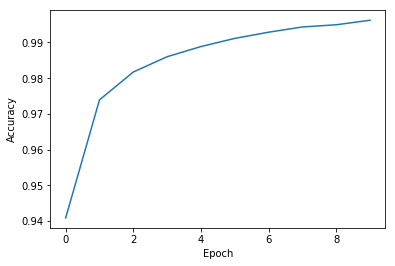

In [22]:
plt.plot(list(range(num_epochs)), hists.history['acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

### (OPTIONAL) Parallelization
Even for a relatively "small" dataset of 60000 images, running just 5 epochs took a long time! Let's try parallelizing the fitting using Ray.

In [23]:
# ray.shutdown()
ray.init(num_cpus = 8)

2019-08-07 20:08:28,297	WARNING worker.py:1373 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-08-07 20:08:28,306	INFO node.py:498 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-08-07_20-08-28_304110_1966/logs.
2019-08-07 20:08:28,431	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:35343 to respond...
2019-08-07 20:08:28,581	INFO services.py:409 -- Waiting for redis server at 127.0.0.1:21157 to respond...
2019-08-07 20:08:28,588	INFO services.py:809 -- Starting Redis shard with 2.58 GB max memory.
2019-08-07 20:08:28,658	INFO node.py:512 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-08-07_20-08-28_304110_1966/logs.
2019-08-07 20:08:28,665	INFO services.py:1475 -- Starting the Plasma object store with 3.87 GB memory using /dev/shm.


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2019-08-07_20-08-28_304110_1966/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-08-07_20-08-28_304110_1966/sockets/raylet',
 'redis_address': '172.28.0.2:35343',
 'session_dir': '/tmp/ray/session_2019-08-07_20-08-28_304110_1966',
 'webui_url': None}

#### Brief Ray Tutorial

You can think of Ray as a big bank. When you *put* money into the bank, you get a receipt with an *ID* number.

In [24]:
deposit_money = 1_000_000
money_id = ray.put(deposit_money)
print(money_id)

ObjectID(0369a14bc595e08cfbd508dfaa162cb7ffffffff)


When you want to *get* your money back, simply give the *ID* of your deposit.

In [25]:
withdrawn_money = ray.get(money_id)
print(withdrawn_money)

1000000


Ray Bank, however, takes 1 business day for every 100,000 dollars to process. 

__IDEA__: instead of depositing $1,000,000 all in one transaction, why not break it down into 10, smaller transactions?

Then, if you want your million dollars back, you can just withdraw from all 10 of your accounts at the same time, getting all $1,000,000 dollars in just 1 business day!

In [26]:
# Withdrawing all $1,000,000 at the same time... SLOW!

import time as t
def withdraw_money(amount):
  num_waiting_days = amount // 100_000
  t.sleep(num_waiting_days)
  
  return amount

start_time = t.perf_counter()

withdrawn_money_slow = withdraw_money(1_000_000)

end_time = t.perf_counter()

display(withdrawn_money_slow,
        str(end_time - start_time) + " seconds"
       )

1000000

'10.010061486999803 seconds'

In [0]:
@ray.remote
def withdraw_money_remote(amount):
  return withdraw_money(amount)

In [28]:
# Withdrawing $100,000 from 10 banks at the same time... FAST!

# Break up the $1,000,000 into ten $100,000's
deposits_money = [100_000]*10

# Deposit your money in 10 separate transactions
deposits_ids = [ray.put(deposit_money) for deposit_money in deposits_money]

### When you want to withdraw...
start_time = t.perf_counter()

# Get your deposit receipt IDs and exchange them all for withdrawal receipt IDs
withdrawal_ids = [withdraw_money_remote.remote(ray.get(deposit_id)) for deposit_id in deposits_ids] # function.remote is basically .put(), but for a function instead of a variable

# Give back all your withdrawal IDs when you get your money.
withdrawals_money = ray.get(withdrawal_ids)

# Recombine the ten 100,000's into your $1,000,000!
withdrawn_money = sum(withdrawals_money)

end_time = t.perf_counter()


display(withdrawn_money,
        str(end_time - start_time) + " seconds"
       )

1000000

'5.6042775599999 seconds'

That concludes this Ray tutorial. Please like and subscribe for more.


## Model Evaluation

In [29]:
nn.evaluate(flat_standard_test_images, dummied_test_labels)

10000/10000 [==============================] - 1s 51us/step


[0.09465404617114759, 0.9815]

While our training accuracy was over 99%, our testing accuracy is a "mere" 98%. Don't worry, this is very typical! Neural networks have a tendency to overfit on the training data.

# Congratulations! You've successfully created a neural network!

Ways to build upon your model:
* Tuning hyperparameters (e.g. different optimizers, loss functions, regularization)
* Changing layers (adding more hidden layers, increasing number of neurons)
* Compare or ensemble results with other classifiers (decision trees, logistic regression)